In [2]:
from typing import Dict
from absl import app
from absl import flags
from absl import logging

import android_env
from dm_env import specs
import numpy as np
import os


In [4]:
print(os.curdir)

.


In [5]:
# 먼저 load 함수를 통해 안드로이드 환경을 불러옵니다. 
# 에뮬레이터가 실행됩니다.
original_env = android_env.load(
      emulator_path='~/Android/Sdk/emulator/emulator',
      android_sdk_root='~/Android/Sdk',
      android_avd_home='~/.android/avd',
      avd_name='my_avd',
      adb_path='~/Android/Sdk/platform-tools/adb',
      #task_path=f'{os.curdir}/tasks/mdp/mdp_0000.textproto',
      task_path=f'{os.curdir}/tasks/mdp/mdp_0003.textproto',
      run_headless=False)

In [11]:

from android_env.wrappers.discrete_action_wrapper import DiscreteActionWrapper
from android_env.wrappers.image_rescale_wrapper import ImageRescaleWrapper
from android_env.wrappers.float_pixels_wrapper import FloatPixelsWrapper
from android_env.wrappers.tap_action_wrapper import TapActionWrapper

def make_env(env):
    print('-'*128)
    print(env.action_spec())
    print()
    print(env.observation_spec())  
    print()
    
    #env = ImageRescaleWrapper(env, zoom_factors=(0.0625, 0.0745),  grayscale=True)
    env = ImageRescaleWrapper(env, zoom_factors=(1/48, 1/27),  grayscale=True)
    
    print('-'*128)
    print(env.action_spec())
    print()
    print(env.observation_spec())  
    print()
    
    env = TapActionWrapper(env, touch_only=False)
    print('-'*128)
    print(env.action_spec())
    print()
    print(env.observation_spec())  
    print()
    
    
    env = DiscreteActionWrapper(env, (6, 9), redundant_actions=False) # action touch grid: 54 blocks
    print('-'*128)
    print(env.action_spec())
    print()
    print(env.observation_spec())  
    print()
    
    env = FloatPixelsWrapper(env)
    
    return env


def make_continuous_env(env):
    print('-'*128)
    print(env.action_spec())
    print()
    print(env.observation_spec())  
    print()
    
    env = ImageRescaleWrapper(env, zoom_factors=(1/24, 1/18),  grayscale=True)
    print('-'*128)
    print(env.action_spec())
    print()
    print(env.observation_spec())  
    print()
    
    env = TapActionWrapper(env, touch_only=True)
    print('-'*128)
    print(env.action_spec())
    print()
    print(env.observation_spec())  
    print()

    env = FloatPixelsWrapper(env)
    print('-'*128)
    print(env.action_spec())
    print()
    print(env.observation_spec())  
    print()
    
    return env



In [12]:
# task의 observation과 action에 대한 정보를 보겠습니다.
# env = make_env(original_env)
env = make_continuous_env(original_env)
action_spec = env.action_spec() 
obs_spec = env.observation_spec()

--------------------------------------------------------------------------------------------------------------------------------
{'action_type': DiscreteArray(shape=(), dtype=int32, name=action_type, minimum=0, maximum=2, num_values=3), 'touch_position': BoundedArray(shape=(2,), dtype=dtype('float32'), name='touch_position', minimum=[0. 0.], maximum=[1. 1.])}

{'pixels': Array(shape=(1920, 1080, 3), dtype=dtype('uint8'), name='pixels'), 'timedelta': Array(shape=(), dtype=dtype('int64'), name='timedelta'), 'orientation': Array(shape=(4,), dtype=dtype('uint8'), name='orientation')}

--------------------------------------------------------------------------------------------------------------------------------
{'action_type': DiscreteArray(shape=(), dtype=int32, name=action_type, minimum=0, maximum=2, num_values=3), 'touch_position': BoundedArray(shape=(2,), dtype=dtype('float32'), name='touch_position', minimum=[0. 0.], maximum=[1. 1.])}

{'pixels': Array(shape=(80, 60, 1), dtype=dtype('

In [13]:
print(type(obs_spec['pixels']))
print(obs_spec['pixels'].minimum)
print(obs_spec['pixels'].maximum)
print(obs_spec['pixels'].shape)



<class 'dm_env.specs.BoundedArray'>
0.0
1.0
(80, 60, 1)


In [7]:
# # 환경을 초기화합니다. 에피소드 처음부터 시작하게 됩니다.

import dm_env
import random
DONE = dm_env.StepType.LAST
#action['touch_position'] = action_index
obs_lst = []
time_step = env.reset()
obs_lst.append(time_step.observation)
while time_step.step_type != DONE:
    action = {}
    action['action_id'] = random.randint(0, 54)
    time_step = env.step(action)
    step_type, reward, discount, obs = time_step
    obs_lst.append(time_step.observation)
    
    if time_step.step_type == DONE:
        break

In [12]:
print(len(obs_lst))
print(obs_lst[0]['pixels'].shape)

3
(120, 80, 1)


In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


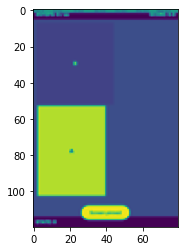

In [17]:
image0 = obs_lst[0]['pixels']
image1 = obs_lst[1]['pixels']
image2 = obs_lst[2]['pixels']

plt.imshow(image0)


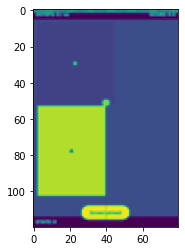

In [18]:
plt.imshow(image1)

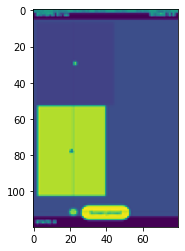

In [19]:
plt.imshow(image2)

In [33]:
step_type, reward, time_delta, obs = time_step

In [34]:
# print(step_type)
# print(reward)
# print(time_delta)   
# # print(obs)


In [35]:
# print(len(_))
# print(_[0])
# print(_[1])
# print(_[2])

# print(_.reward)
# print(_.discount)
# print(_.observation['pixels'].shape)
# print(_.observation['pixels'][0])
# print(_.observation['pixels'][0].shape)
# print(_.observation['orientation'])
# print(_.observation['timedelta'])

In [36]:
def get_random_action() -> Dict[str, np.ndarray]:
    """Returns a random AndroidEnv action."""
    action = {}
    for k, v in action_spec.items():
        if isinstance(v, specs.DiscreteArray):
            action[k] = np.random.randint(low=0, high=v.num_values, dtype=v.dtype)
        else:
            action[k] = np.random.random(size=v.shape).astype(v.dtype)
    return action

In [37]:
import numpy as np
import random
import torch
import torch.optim as optim
from models.DQN import ClassicCNN, train_dqn
from buffer.replay_buffer import ReplayBuffer
from utils import *
from torch.utils.tensorboard import SummaryWriter
import os

In [38]:
print(env.action_spec())
print(env.action_spec()['action_id'].num_values)
print(env.observation_spec())
print(env.observation_spec()['pixels'])
print(env.observation_spec()['pixels'].shape)


{'action_id': DiscreteArray(shape=(), dtype=int32, name=action_id, minimum=0, maximum=53, num_values=54)}
54
{'pixels': Array(shape=(120, 80, 1), dtype=dtype('uint8'), name='pixels'), 'timedelta': Array(shape=(), dtype=dtype('int64'), name='timedelta'), 'orientation': Array(shape=(4,), dtype=dtype('uint8'), name='orientation')}
Array(shape=(120, 80, 1), dtype=dtype('uint8'), name='pixels')
(120, 80, 1)


In [39]:
print(env.action_spec().items())

dict_items([('action_id', DiscreteArray(shape=(), dtype=int32, name=action_id, minimum=0, maximum=53, num_values=54))])


In [40]:
import dm_env

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
FIRST = dm_env.StepType.FIRST
DONE = dm_env.StepType.LAST
GAMMA=0.9
MEMORY_SIZE = 50000
BATCH_SIZE = 128   # 32
LEARNING_RATE = 0.000625   # 0.01
TARGET_UPDATE = 10  # 5
SAVE_PATH = "/home/slowlab/android_env_tutorial/weights/dqn/"
MODEL_NAME = 'DQN'
ENV_NAME = 'mdp_0000'
SAVE_PERIOD = 100
START_SIZE = 2000



def converter(obs):
    if len(obs['pixels'].shape) < 4:
        obs_pixels = obs['pixels']
        obs_pixels = obs_pixels.transpose(2, 0, 1)
        obs_tensor = torch.tensor(obs_pixels).to(device).float()
        obs_tensor = obs_tensor.unsqueeze(0)
    else:
        obs_pixels = obs_pixels.transpose(2, 0, 1)
        obs_tensor = torch.tensor(obs_pixels).to(device).float()
        obs_tensor = obs_tensor.unsqueeze(0)
    return obs_tensor

In [41]:

def main():
    summary_path = "/home/slowlab/android_env_tutorial/experiments/dqn/train{}".format(ENV_NAME)
    if not os.path.isdir(summary_path):
        os.mkdir(summary_path)
    writer = SummaryWriter(summary_path)
    
    startEpsilon = 0.95
    endEpsilon = 0.05
    total_episodes = 10000
    #total_steps = 100000
    epsilon = startEpsilon
    stepDrop = (startEpsilon - endEpsilon)  * 5 / total_episodes
    n_actions = env.action_spec()['action_id'].num_values
    state_dim = env.observation_spec()['pixels'].shape
    H, W, C = state_dim[0], state_dim[1], state_dim[2]
    print(H, W, C)
    behavior_policy = ClassicCNN(C, H, W, 3, 2, n_actions).to(device).float()    # C, H, W, K, S, num_actions
    target_policy = ClassicCNN(C, H, W, 3, 2, n_actions).to(device).float()
    target_policy.load_state_dict(behavior_policy.state_dict())
    optimizer = optim.Adam(behavior_policy.parameters(), lr=LEARNING_RATE)
    memory = ReplayBuffer(MEMORY_SIZE)

    # return Timestep object (step_type, reward, time_delta, obs)
    
    for episode in range(total_episodes):
        if(epsilon > endEpsilon):
            epsilon -= stepDrop
        total_rewards = 0
        timestep = env.reset()
        loss = 0
        #step_type, reward, discount, obs = timestep
        
        while not timestep.last():
            action_index = behavior_policy.sample_action(timestep.observation, epsilon)
            action = {}
            action['action_id'] = action_index
            #action['touch_position'] = action_index
        
            next_timestep = env.step(action=action)
            total_rewards += next_timestep.reward
            
            if next_timestep.step_type == DONE:
                print(f'total_rewards of episode {episode}: {total_rewards}')
                print(f"# of transitions in memory: {memory.size()}")
                writer.add_scalar("total_rewards", total_rewards, episode)
                writer.add_scalar("epsilon", epsilon, episode)
                writer.add_scalar("loss", loss, episode)
                break
        
            transition = (timestep, action, next_timestep)
            memory.put(transition)
            timestep = next_timestep
            if memory.size() > START_SIZE:
                loss = train_dqn(behavior_policy, target_policy, memory, optimizer, GAMMA, BATCH_SIZE)
    
        if episode % TARGET_UPDATE == 0:
            target_policy.load_state_dict(behavior_policy.state_dict())
        save_model(episode, SAVE_PERIOD, SAVE_PATH,target_policy, MODEL_NAME)
        

    writer.close()
main()

        


120 80 1
8065
8065


KeyError: 'time_delta'

In [ ]:
# save_model(step, SAVE_PERIOD, SAVE_PATH,target_policy, MODEL_NAME)


In [ ]:
# def eval():
#     writer = SummaryWriter("/home/slowlab/android_env_tutorial/experiments/dqn/test")

#     total_steps = 10000
#     n_actions = env.action_spec()['action_id'].num_values
#     state_dim = env.observation_spec()['pixels'].shape
#     H, W, C = state_dim[0], state_dim[1], state_dim[2]
#     print(H, W, C)
#     behavior_policy = ClassicCNN(C, H, W, 3, 2, n_actions).to(device).float()    # C, H, W, K, S, num_actions
#     SAVE_PATH = "/home/slowlab/android_env_tutorial/weights/dqn/DQN495000.pt"
#     load_model(behavior_policy, SAVE_PATH)
    
#     total_rewards = 0
#     epsilon = 0.0
#     step_type, reward, discount, obs = env.reset() # return Timestep object (step_type, reward, time_delta, obs)
#     for step in range(total_steps):
#         action_index = behavior_policy.sample_action(converter(obs), epsilon)
#         action = {}
#         action['action_id'] = action_index
#         step_type, reward, discount, next_obs = env.step(action=action)
#         writer.add_scalar("reward", reward, step)
#         total_rewards += reward
#         writer.add_scalar("total_rewards", total_rewards, step)
#         obs = next_obs

#     writer.close()
# eval()

120 80 1
8064
